In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0


#tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

2.9.2


In [2]:
!pip install -q tensorflow-datasets

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUWHB02/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUWHB02/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUWHB02/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 24s 18ms/step - loss: 0.5039 - accuracy: 0.7318 - val_loss: 0.3663 - val_accuracy: 0.8432
Epoch 2/50
782/782 [==============================] - 13s 16ms/step - loss: 0.3073 - accuracy: 0.8764 - val_loss: 0.3566 - val_accuracy: 0.8464
Epoch 3/50
782/782 [==============================] - 13s 16ms/step - loss: 0.2444 - accuracy: 0.9061 - val_loss: 0.3624 - val_accuracy: 0.8420
Epoch 4/50
782/782 [==============================] - 13s 17ms/step - loss: 0.1980 - accuracy: 0.9268 - val_loss: 0.3961 - val_accuracy: 0.8337
Epoch 5/50
782/782 [==============================] - 13s 16ms/step - loss: 0.1544 - accuracy: 0.9455 - val_loss: 0.5060 - val_accuracy: 0.8307
Epoch 6/50
782/782 [==============================] - 14s 17ms/step - loss: 0.1118 - accuracy: 0.9622 - val_loss: 0.5290 - val_accuracy: 0.8226
Epoch 7/50
782/782 [==============================] - 13s 17ms/step - loss: 0.0737 - accuracy: 0.9757 - val_loss: 0.6345 - val_accuracy:

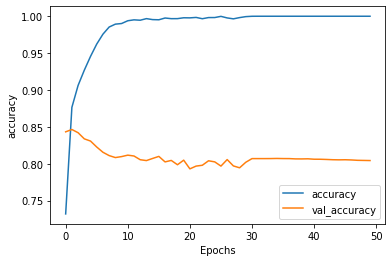

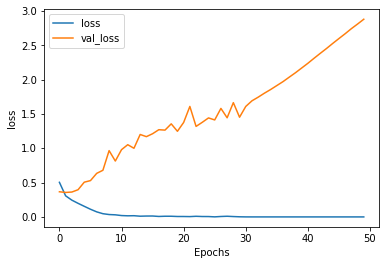

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [10]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 10
history_lstm = model_lstm.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 13s 17ms/step - loss: 0.1114 - accuracy: 0.9626 - val_loss: 0.5629 - val_accuracy: 0.8233
Epoch 2/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0899 - accuracy: 0.9713 - val_loss: 0.6895 - val_accuracy: 0.8073
Epoch 3/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0666 - accuracy: 0.9803 - val_loss: 0.7459 - val_accuracy: 0.8189
Epoch 4/10
782/782 [==============================] - 14s 18ms/step - loss: 0.0597 - accuracy: 0.9821 - val_loss: 0.8321 - val_accuracy: 0.8175
Epoch 5/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0471 - accuracy: 0.9857 - val_loss: 0.9880 - val_accuracy: 0.8201
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0409 - accuracy: 0.9871 - val_loss: 0.9313 - val_accuracy: 0.8144
Epoch 7/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0346 - accuracy: 0.9895 - val_loss: 1.0359 - val_accuracy:

In [14]:
# Model Definition with Conv1D
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_cnn.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [15]:
num_epochs = 10
history_cnn = model_cnn.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 10s 8ms/step - loss: 0.4535 - accuracy: 0.7724 - val_loss: 0.3457 - val_accuracy: 0.8497
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2796 - accuracy: 0.8862 - val_loss: 0.3766 - val_accuracy: 0.8340
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2263 - accuracy: 0.9116 - val_loss: 0.3814 - val_accuracy: 0.8398
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1909 - accuracy: 0.9274 - val_loss: 0.4077 - val_accuracy: 0.8358
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1609 - accuracy: 0.9428 - val_loss: 0.4717 - val_accuracy: 0.8216
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.1317 - accuracy: 0.9546 - val_loss: 0.4973 - val_accuracy: 0.8237
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1080 - accuracy: 0.9660 - val_loss: 0.5785 - val_accuracy: 0.8160
Epoch